# Qredo tokenomics simulation - staking rewards parameters

### June 2023

## 1. Imports

In [5]:
import os
import pickle
import pandas as pd
import numpy as np
import itertools
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [6]:
forecast_length = 365*2
outfolder = os.path.realpath("../data/sim_data")

## 2. Load and process data

In [84]:
# load
df_file = os.path.join(outfolder, f"sample_by_staking_params_and_scenario.pickle")
with open(df_file, "rb") as fp:
    df = pickle.load(fp)  

# process columns
df["apr"] = 365.0*(df["total_staking_rewards"]-df["validators_rewards"])/df["staking_tvl"]
df["tvl_rate"] = df["staking_tvl"]/df["circ_supply"]
df["validator_reward_share"] = df["validator_reward_share"].round(2)
df["av_validator_reward"] = df["validators_rewards"] / df["n_validators"]
df["validator_profit"] = df["av_validator_reward"] * df["token_price"] - 100.0
df["decay_rate"] = (
    np.where(
        df["staking_rewards_vesting_decay_rate"]==np.log(2) / (6.0 * 365),
        "6yrs half-life",
        "4yrs half-life")
)
df["release_rate_a"] = df["release_rate_a"].round(1)
df["release_rate_fn"] = "a=" + df["release_rate_a"].astype(str) + " max_rate=" + df["release_rate_max"].astype(str)
df["date"] = df["iteration"].apply(lambda x: dt.datetime(2023, 6, 15)+dt.timedelta(days=x)).values

# convert units
mill_cols = ["circ_supply", 'day_vested', 'day_locked', 'day_released',"ecosystem_fund", "staking_tvl"]
df[mill_cols] = df[mill_cols]/(10**6)
thou_cols = ["validators_rewards", 'total_staking_rewards','staking_rewards_vested','staking_rewards_ecosystem']
df[thou_cols] = df[thou_cols]/(10**3)

len(df)

6937920

In [85]:
base_df = df[df["token_scenario"]=="base"]
combined_df = df[(df["staking_scenario"]==df["usage_scenario"]) & (df["staking_scenario"]==df["token_scenario"])]
combined_df["combined_scenario"] = combined_df["staking_scenario"]

## 3. Reward sources

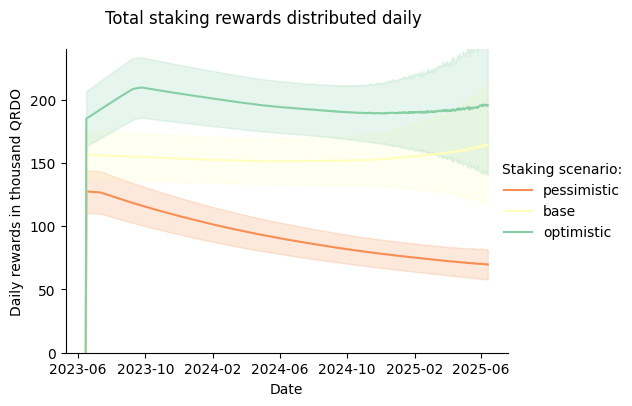

In [53]:
g = sns.relplot(data=df, x="date", y="total_staking_rewards", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Daily rewards in thousand QRDO")
  ._legend.set_title('Staking scenario:')
)
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.ylim(0,240)
plt.suptitle("Total staking rewards distributed daily")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.18, 0.5])
plt.show()

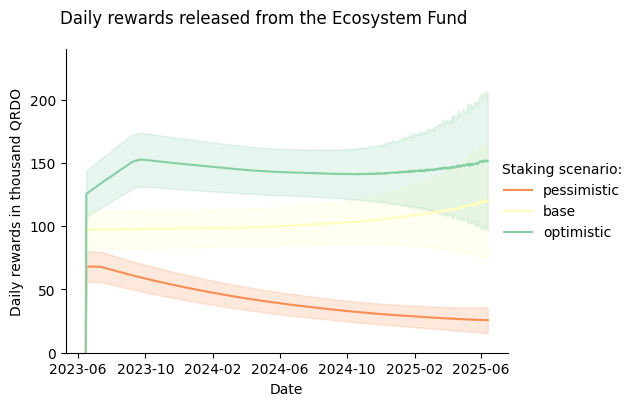

In [54]:
g = sns.relplot(data=df, x="date", y="staking_rewards_ecosystem", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Daily rewards in thousand QRDO")
  ._legend.set_title('Staking scenario:')
)
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.ylim(0,240)
plt.suptitle("Daily rewards released from the Ecosystem Fund")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.18, 0.5])
plt.show()

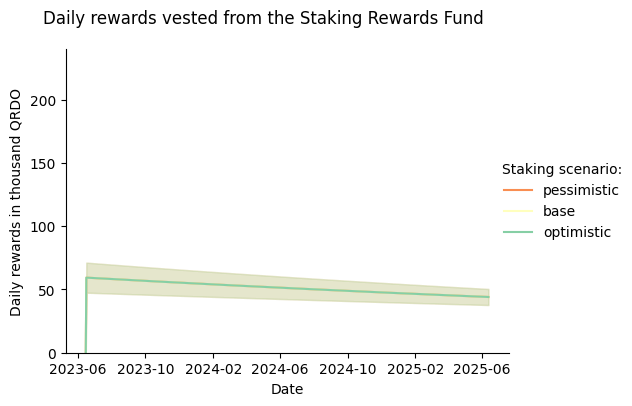

In [55]:
g = sns.relplot(data=df, x="date", y="staking_rewards_vested", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Daily rewards in thousand QRDO")
  ._legend.set_title('Staking scenario:')
)
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.ylim(0,240)
plt.suptitle("Daily rewards vested from the Staking Rewards Fund")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.18, 0.5])
plt.show()

## 4. Parameter analysis - Validator reward share

### 4.1 Staker APR

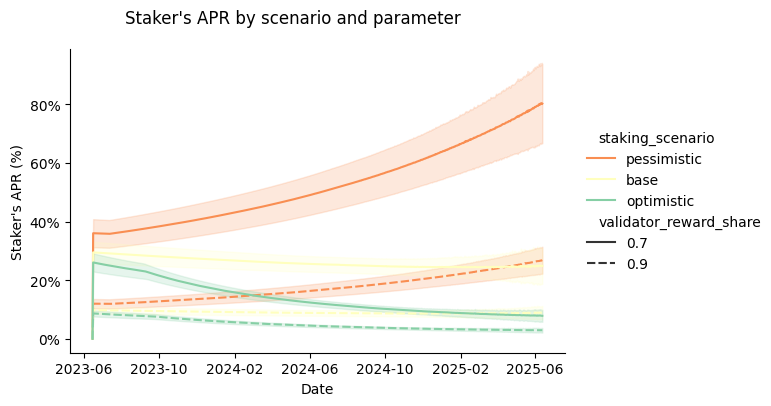

In [56]:
g = sns.relplot(data=df, x="date", y="apr", style="validator_reward_share", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
g.set_axis_labels("Date", "Staker's APR (%)")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.suptitle("Staker's APR by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.3, 0.5])
plt.show()

In [57]:
df.groupby(["staking_scenario", "validator_reward_share"])["apr"].mean()

staking_scenario  validator_reward_share
base              0.7                       0.260070
                  0.9                       0.090080
optimistic        0.7                       0.139485
                  0.9                       0.049651
pessimistic       0.7                       0.523260
                  0.9                       0.174411
Name: apr, dtype: float64

### 4.2 Validator profit

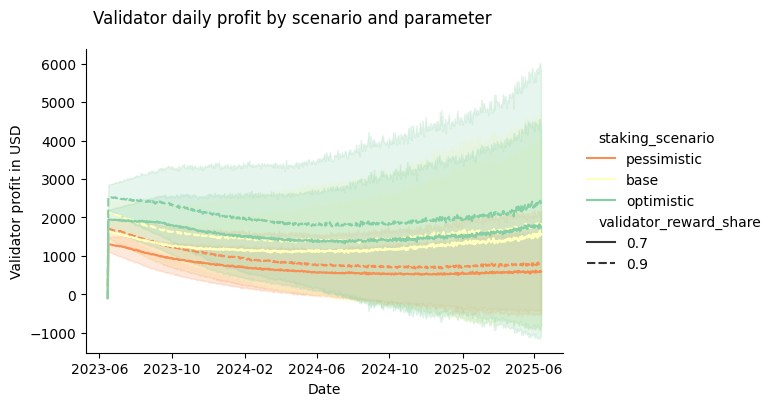

In [58]:
g = sns.relplot(data=df, x="date", y="validator_profit", style="validator_reward_share", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
g.set_axis_labels("Date", "Validator profit in USD")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.suptitle("Validator daily profit by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.3, 0.5])
plt.show()

In [59]:
df.groupby(["staking_scenario", "validator_reward_share"])["validator_profit"].mean()

staking_scenario  validator_reward_share
base              0.7                       1254.577675
                  0.9                       1557.668608
optimistic        0.7                       1567.859541
                  0.9                       2040.822241
pessimistic       0.7                        688.899595
                  0.9                        916.168154
Name: validator_profit, dtype: float64

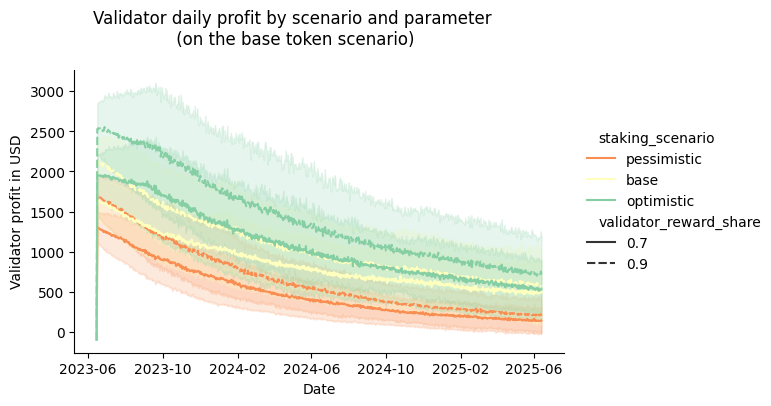

In [60]:
g = sns.relplot(data=base_df, x="date", y="validator_profit", style="validator_reward_share", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
g.set_axis_labels("Date", "Validator profit in USD")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.suptitle("Validator daily profit by scenario and parameter\n (on the base token scenario)")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.3, 0.5])
plt.show()

In [61]:
base_df.groupby(["iteration","staking_scenario", "validator_reward_share"])["validator_profit"].mean().tail(6)

iteration  staking_scenario  validator_reward_share
729        base              0.7                       492.876202
                             0.9                       569.498469
           optimistic        0.7                       533.474422
                             0.9                       718.566518
           pessimistic       0.7                       143.208051
                             0.9                       199.707279
Name: validator_profit, dtype: float64

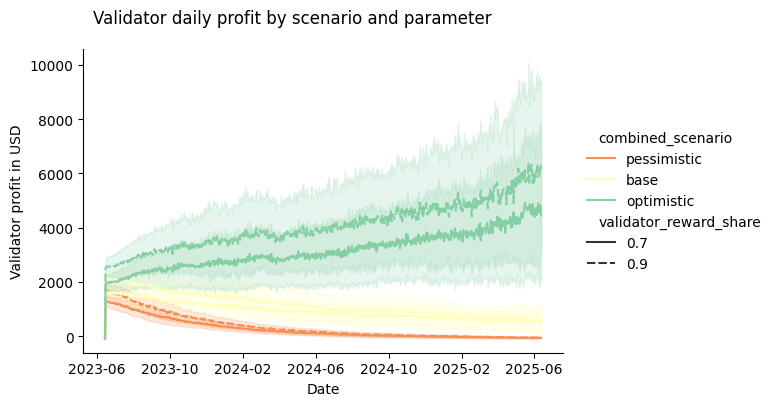

In [63]:
g = sns.relplot(data=combined_df, x="date", y="validator_profit", style="validator_reward_share", hue="combined_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
g.set_axis_labels("Date", "Validator profit in USD")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.suptitle("Validator daily profit by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.3, 0.5])
plt.show()

In [64]:
combined_df.groupby(["combined_scenario", "validator_reward_share"])["validator_profit"].mean()

combined_scenario  validator_reward_share
base               0.7                        932.736992
                   0.9                       1175.021734
optimistic         0.7                       3153.439112
                   0.9                       4078.105353
pessimistic        0.7                        245.964631
                   0.9                        344.602806
Name: validator_profit, dtype: float64

## 5. Parameter analysis - vesting decay rate

In [86]:
vest_df = df[df["validator_reward_share"]==0.9]
vest_comb_df = combined_df[combined_df["validator_reward_share"]==0.9]

### 5.1 Staker APR

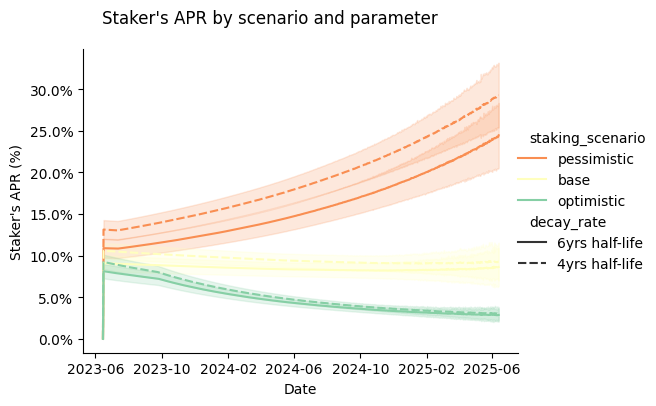

In [92]:
g = sns.relplot(data=vest_df, x="date", y="apr", style="decay_rate", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
g.set_axis_labels("Date", "Staker's APR (%)")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.suptitle("Staker's APR by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.2, 0.5])
plt.show()

In [88]:
vest_df.groupby(["staking_scenario", "decay_rate"])["apr"].mean()

staking_scenario  decay_rate    
base              4yrs half-life    0.095327
                  6yrs half-life    0.084833
optimistic        4yrs half-life    0.051945
                  6yrs half-life    0.047358
pessimistic       4yrs half-life    0.191124
                  6yrs half-life    0.157698
Name: apr, dtype: float64

### 5.2 Validator profit

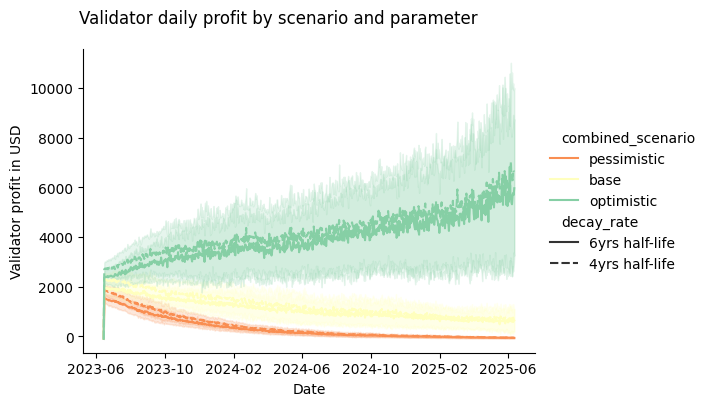

In [102]:
g = sns.relplot(data=vest_comb_df, x="date", y="validator_profit", style="decay_rate", hue="combined_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
g.set_axis_labels("Date", "Validator profit in USD")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.suptitle("Validator daily profit by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.25, 0.5])
plt.show()

In [90]:
vest_comb_df.groupby(["staking_scenario", "decay_rate"])["validator_profit"].mean()

staking_scenario  decay_rate    
base              4yrs half-life    1259.169268
                  6yrs half-life    1090.874200
optimistic        4yrs half-life    4263.111505
                  6yrs half-life    3893.099200
pessimistic       4yrs half-life     387.016828
                  6yrs half-life     302.188783
Name: validator_profit, dtype: float64

In [104]:
vest_comb_df.groupby(["staking_scenario", "decay_rate"])["validator_profit"].mean().pct_change()

staking_scenario  decay_rate    
base              4yrs half-life         NaN
                  6yrs half-life   -0.133656
optimistic        4yrs half-life    2.907977
                  6yrs half-life   -0.086794
pessimistic       4yrs half-life   -0.900589
                  6yrs half-life   -0.219184
Name: validator_profit, dtype: float64

### 5.3 Inflation rates

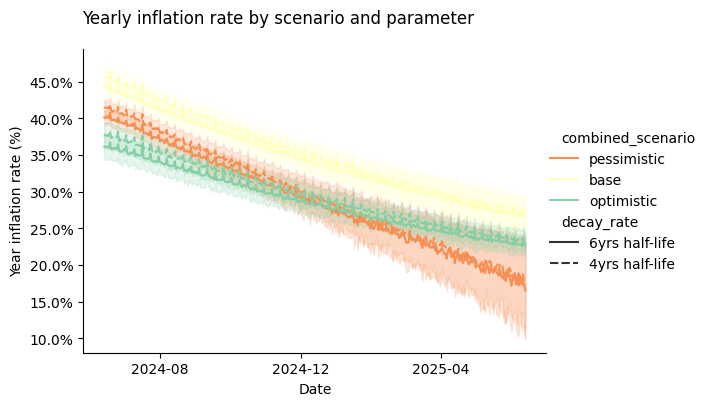

In [103]:
g = sns.relplot(data=vest_comb_df, x="date", y="year_inflation", style="decay_rate", hue="combined_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
g.set_axis_labels("Date", "Year inflation rate (%)")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.suptitle("Yearly inflation rate by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.25, 0.5])
plt.show()

In [98]:
vest_comb_df.groupby(["combined_scenario", "decay_rate"])["year_inflation"].mean()

combined_scenario  decay_rate    
base               4yrs half-life    0.353327
                   6yrs half-life    0.344795
optimistic         4yrs half-life    0.297282
                   6yrs half-life    0.287548
pessimistic        4yrs half-life    0.295057
                   6yrs half-life    0.287101
Name: year_inflation, dtype: float64

## 6. Parameter analysis - release rate function

In [110]:
release_df = vest_df[vest_df["decay_rate"]=="4yrs half-life"]
release_comb_df = vest_comb_df[vest_comb_df["decay_rate"]=="4yrs half-life"]

### 6.1 Parameter space

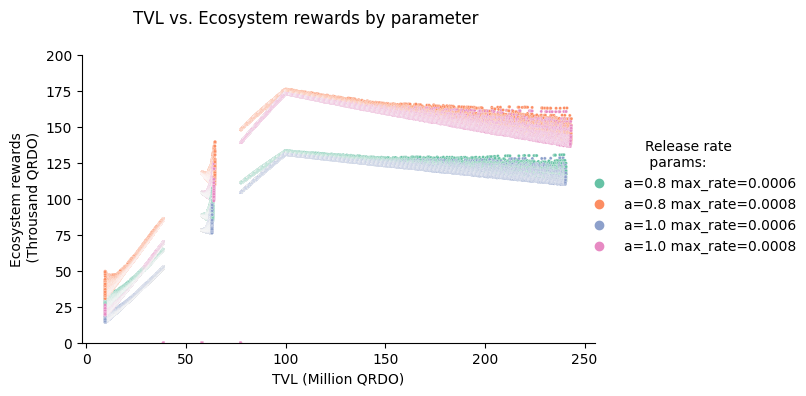

In [115]:
g = sns.relplot(data=release_comb_df, x="staking_tvl", y="staking_rewards_ecosystem", hue="release_rate_fn",
                kind="scatter", palette="Set2", height=4, aspect=1, s=5)
(g.set_axis_labels("TVL (Million QRDO)", "Ecosystem rewards\n (Throusand QRDO)")
  ._legend.set_title('Release rate \n params:')
)
plt.suptitle("TVL vs. Ecosystem rewards by parameter")
plt.ylim(0,200)
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.3, 0.5])
plt.show()

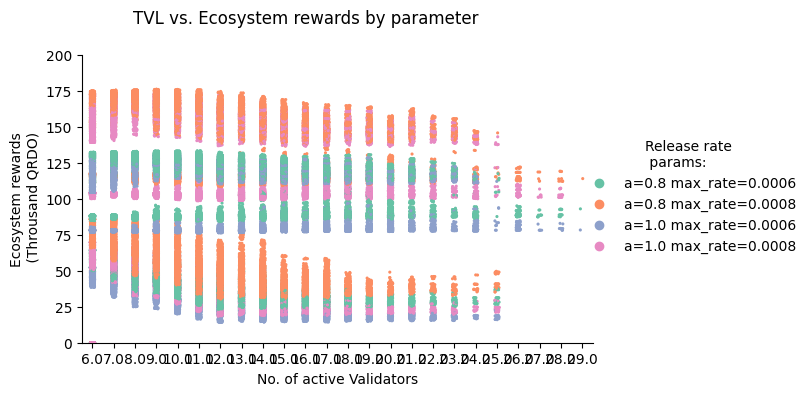

In [116]:
g = sns.catplot(data=release_comb_df, x="n_validators", y="staking_rewards_ecosystem", hue="release_rate_fn",
                kind="strip", palette="Set2", height=4, aspect=1, s=5)
(g.set_axis_labels("No. of active Validators", "Ecosystem rewards\n (Throusand QRDO)")
  ._legend.set_title('Release rate \n params:')
)
plt.suptitle("TVL vs. Ecosystem rewards by parameter")
plt.ylim(0,200)
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.3, 0.5])
plt.show()

### 6.2 Staker APR

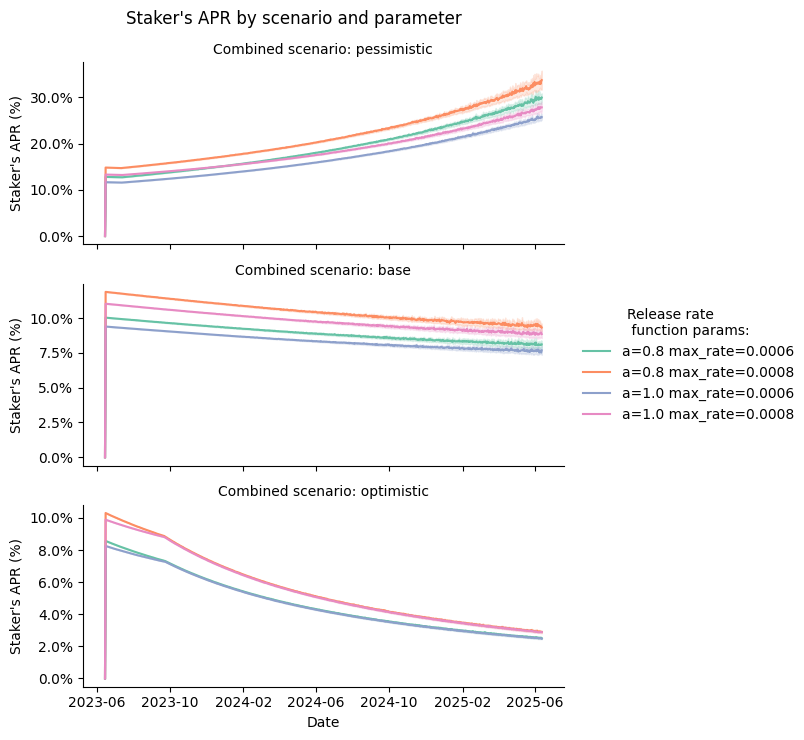

In [132]:
g = sns.relplot(data=release_comb_df, x="date", y="apr", hue="release_rate_fn", row="combined_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=2.5, aspect=1.5, facet_kws={"sharey": False})
(g.set_axis_labels("Date", "Staker's APR (%)")
  .set_titles("Combined scenario: {row_name}")
  ._legend.set_title('Release rate\n function params:')
)
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
g.axes[1][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
g.axes[2][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))

plt.suptitle("Staker's APR by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.35, 0.5])
plt.show()

In [127]:
release_comb_df.groupby(["combined_scenario", "release_rate_fn"])["apr"].mean()

combined_scenario  release_rate_fn      
base               a=0.8 max_rate=0.0006    0.089104
                   a=0.8 max_rate=0.0008    0.104626
                   a=1.0 max_rate=0.0006    0.083637
                   a=1.0 max_rate=0.0008    0.097798
optimistic         a=0.8 max_rate=0.0006    0.047064
                   a=0.8 max_rate=0.0008    0.055971
                   a=1.0 max_rate=0.0006    0.046535
                   a=1.0 max_rate=0.0008    0.055324
pessimistic        a=0.8 max_rate=0.0006    0.191910
                   a=0.8 max_rate=0.0008    0.215658
                   a=1.0 max_rate=0.0006    0.169000
                   a=1.0 max_rate=0.0008    0.185721
Name: apr, dtype: float64

### 6.3 Validator Profit

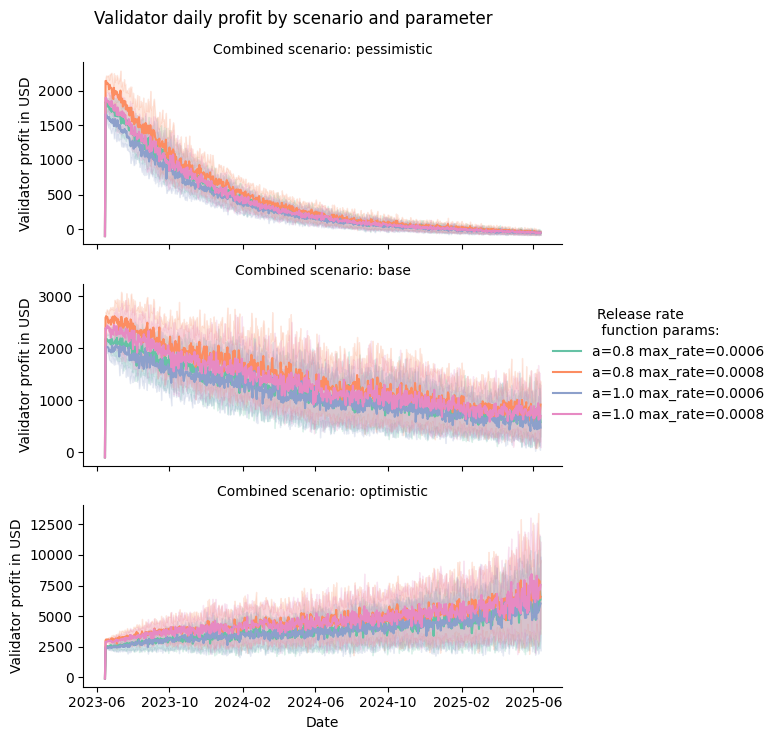

In [131]:
g = sns.relplot(data=release_comb_df, x="date", y="validator_profit", hue="release_rate_fn", row="combined_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=2.5, aspect=1.5,facet_kws={"sharey": False})
(g.set_axis_labels("Date", "Validator profit in USD")
  .set_titles("Combined scenario: {row_name}")
  ._legend.set_title('Release rate\n function params:')
)
g.axes[-1][-1].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.suptitle("Validator daily profit by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.3, 0.5])
plt.show()

In [126]:
release_comb_df.groupby(["combined_scenario", "release_rate_fn"])["validator_profit"].mean()

combined_scenario  release_rate_fn      
base               a=0.8 max_rate=0.0006    1186.722248
                   a=0.8 max_rate=0.0008    1426.334737
                   a=1.0 max_rate=0.0006    1104.991219
                   a=1.0 max_rate=0.0008    1318.628867
optimistic         a=0.8 max_rate=0.0006    3916.345819
                   a=0.8 max_rate=0.0008    4659.527974
                   a=1.0 max_rate=0.0006    3858.271911
                   a=1.0 max_rate=0.0008    4618.300318
pessimistic        a=0.8 max_rate=0.0006     381.959407
                   a=0.8 max_rate=0.0008     449.412283
                   a=1.0 max_rate=0.0006     331.985765
                   a=1.0 max_rate=0.0008     384.709856
Name: validator_profit, dtype: float64